# Image Recognation Project Dataset

<b>CIFAR-10</b> is by now a classical computer-vision dataset for object recognition case study. It is a subset of the 80 million tiny images dataset that was designed and created by the Canadian Institute for Advanced Research (CIFAR, pronounced "see far").
The CIFAR-10 dataset consists of 60000 <b>32x32x3</b> color images in 10 equal classes, (6000 images per class). Each class of images corresponds to a physical object (automobile, cat, dog, airplane, etc).
Dataset website: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:

## Look at the current directory
%ls

gdrive/  sample_data/


In [3]:
## Change the current dire
#%cd 'gdrive/My Drive/CIFAR_Image_Recognition'
%cd "gdrive/MyDrive/dscamp/dscamp_public/Project Object Recognition/Tutorials/3 Examples"

/content/gdrive/MyDrive/dscamp/dscamp_public/Project Object Recognition/Tutorials/3 Examples


# Import Data and Packages

In [11]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical  # Use to_categorical instead of np_utils
from keras.constraints import MaxNorm
#from keras.utils import np_utils
from keras.layers import GaussianNoise
#from keras.layers.advanced_activations import SReLU
#from keras.utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
import os, sys, time, datetime, fnmatch
import numpy as np
import dlutils
import kerutils
from dlutils import *
from kerutils import *

The CIFAR-10 image classes are encoded as integers 0-9 by the following Python dictionary

In [6]:
nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

Loading Training and test data

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])  # somehow y_train comes as a 2D nx1 matrix
y_test = y_test.reshape(y_test.shape[0])

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'validation samples')

170498071/170498071 [==============================] - 12s 0us/step
X_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples


The original data of each image is a 32x32x3 matrix of integers from 0 to 255. We need to scale it down to floats in the unit interval

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

As usual, we must convert the y_train and y_test vectors to one-hot format:<br>
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]<br>
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]<br>
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]<br>
3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]<br>
etc...

In [12]:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

Let's also write two small utilities for drawing samples of images, so we can inspect our results visually.

In [13]:
def draw_img(i):
    im = X_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (c, class_name[c]))
    plt.axis('on')

def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(32,32,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name[y[n+i]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        #plt.subplots_adjust(hspace=0.45, wspace=0.45)
        #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if imfile:
        plt.savefig(imfile)

Let's draw image 7 in X_train for example

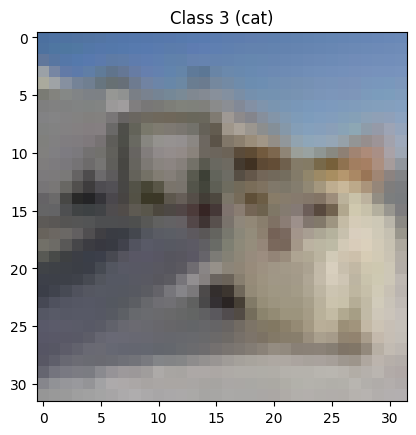

In [14]:
draw_img(80)

To test the second utility, let's draw the first 15 images in a 3x5 grid:

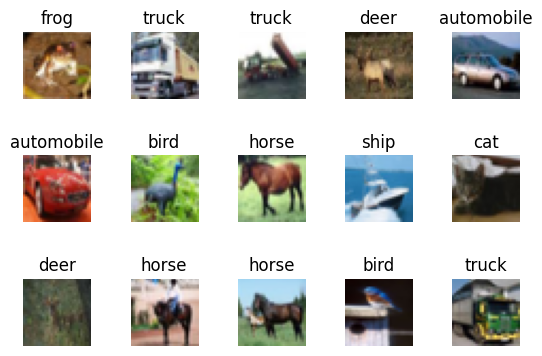

In [15]:
draw_sample(X_train, y_train, 0,3,5)

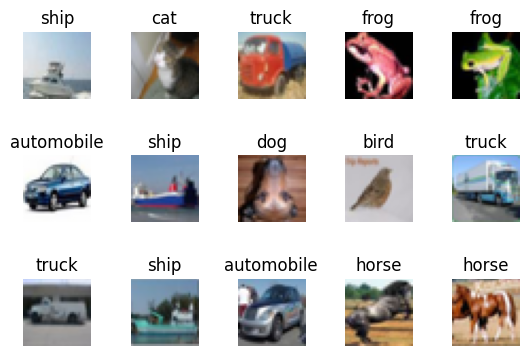

In [16]:
draw_sample(X_train, y_train, 100, 3, 5)

Some functions for plotting

In [17]:
def show_scores1(model, h, X_train, Y_train, X_test, Y_test):
    loss, acc = model.evaluate(X_train, Y_train, verbose=0)
    print ("Training: accuracy   = %.6f loss = %.6f" % (acc, loss))
    loss, acc = model.evaluate(X_test, Y_test, verbose=0)
    print ("Validation: accuracy = %.6f loss = %.6f" % (acc, loss))
    if 'val_acc' in h.history:
        print ("Over fitting score   = %.6f" % over_fitting_score(h))
        print ("Under fitting score  = %.6f" % under_fitting_score(h))
    print ("Params count:", model.count_params())
    print ("stop epoch =", max(h.epoch))
    print ("nb_epoch =", h.params['epochs'])
    #print ("batch_size =", h.params['batch_size'])
    #print ("nb_sample =", h.params['samples'])
    view_acc1(h)
    id = model.name[-1]
    plt.savefig(model.name + '_acc_graph.png')
    plt.show()
    view_loss(h)
    plt.savefig(model.name + '_loss_graph.png')
    plt.show()


In [18]:
def view_acc1(h):
    # Accuracy history graph
    plt.plot(h.history['accuracy'])
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    leg = plt.legend(['train', 'validation'], loc='best')
    plt.setp(leg.get_lines(), linewidth=3.0)


# Building Neural Network for the image set

The input layer would have to be of size 3072 (as every image is a 32x32x3 matrix). If we add a hidden layer with the same size, we'll end up with 9 milion synapses on the first floor. Adding one more layer of such size will take us to billions of synapses, which is of course impractical.<br>
Deep learning frameworks have come up with special types of designated layers for processing images. Each image pixel is connected to a very small subset of pixels of size 3x3 or 5x5 in its neighborhood. Intuitively, image pixels are mostly impacted by pixels around them rather than pixels in a far away region of the image.<br>
We will start with a small Keras model which combines a well thought mix of <b>Convolution2D</b>, <b>Maxpooling2D</b> and Dense layers.<br>


We will use two types of training:<br>
<b>Standard training</b>: the usual Keras fit method<br>



# Let's Train Model

1. mini-batch gradient descent

In [19]:
nb_epoch = 10
batch_size = 64

model0 = Sequential()
model0.add(Convolution2D(5, 2, 2, input_shape=(32, 32, 3), padding='same',  activation='relu')) # add parameters and activation function
model0.add(Convolution2D(20, 2, 2, activation='relu')) # add parameters and activation function
model0.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model0.add(Flatten())
model0.add(Dense(32, activation='relu')) # add parameters and activation function
model0.add(Dense(nb_classes, activation='softmax')) # activation function
# Compile model
model0.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
print(model0.summary())
print('Standard Training.')
h0 = model0.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 5)         65        
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 20)          420       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 20)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 32)                10272     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                        

2. Mini-batch gradient with momentum

In [20]:
nb_epoch = 10
batch_size = 64

model1 = Sequential()
model1.add(Convolution2D(5, 2, 2, input_shape=(32, 32, 3), padding='same',  activation='relu')) # add parameters and activation function
model1.add(Convolution2D(20, 2, 2, activation='relu')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model1.add(Flatten())
model1.add(Dense(32, activation='relu')) # add parameters and activation function
model1.add(Dense(nb_classes, activation='softmax')) # activation function
optimizer = SGD(momentum=0.9)

# Compile model
model1.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
print(model1.summary())

print('Standard Training.')

h1 = model1.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)

# print('Saving model1 to the file "model_1.h5"')
# model1.save("model_1.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 5)         65        
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 20)          420       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 20)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                10272     
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                      

3. Adam

In [21]:
nb_epoch = 30
batch_size = 64

model2 = Sequential()
model2.add(Convolution2D(5, 2, 2, input_shape=(32, 32, 3), padding='same',  activation='relu')) # add parameters and activation function
#model2.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model2.add(Convolution2D(20, 2, 2, activation='relu')) # add parameters and activation function
model2.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
# model2.add(Convolution2D(30, 2, 2, activation='relu', kernel_initializer= 'he_normal')) # add parameters and activation function
# model2.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model2.add(Flatten())
model2.add(Dense(32, activation='relu')) # add parameters and activation function
model2.add(Dense(nb_classes, activation='softmax')) # activation function
# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

print('Standard Training.')

h2 = model2.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 5)         65        
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 20)          420       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 20)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                10272     
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                      

Plot the accuracy and compare

Training: accuracy   = 0.441040 loss = 1.622327
Validation: accuracy = 0.438300 loss = 1.627003
Params count: 11087
stop epoch = 9
nb_epoch = 10


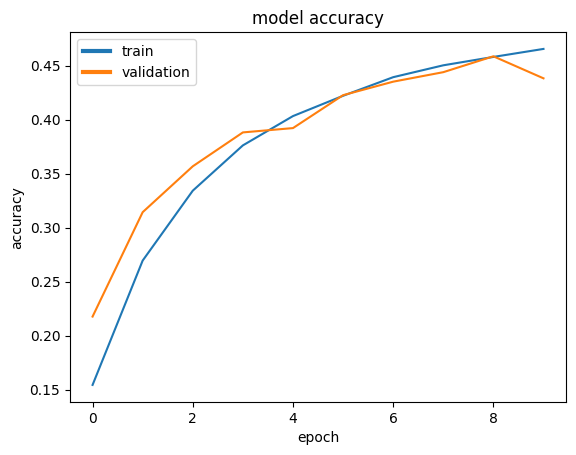

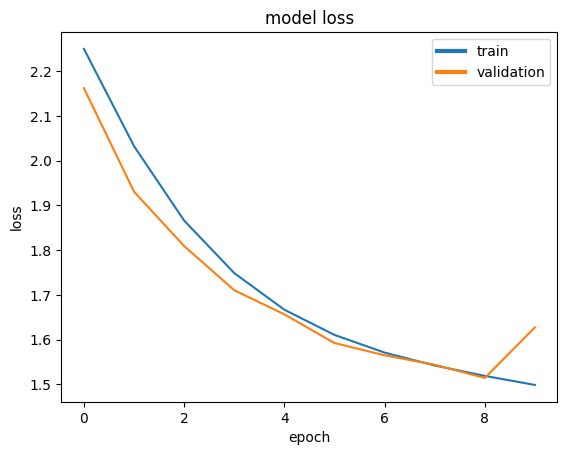

In [22]:
# mini-batch
show_scores1(model0, h0, X_train, Y_train, X_test, Y_test)

Training: accuracy   = 0.563440 loss = 1.237517
Validation: accuracy = 0.532100 loss = 1.322119
Params count: 11087
stop epoch = 9
nb_epoch = 10


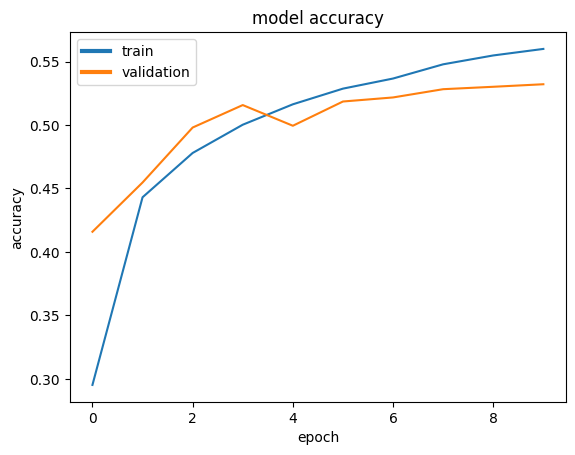

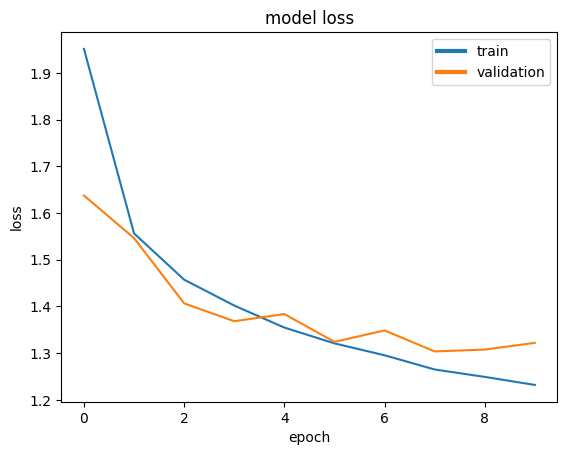

In [23]:
# momentum
show_scores1(model1, h1, X_train, Y_train, X_test, Y_test)

Training: accuracy   = 0.621820 loss = 1.063291
Validation: accuracy = 0.581300 loss = 1.186842
Params count: 11087
stop epoch = 29
nb_epoch = 30


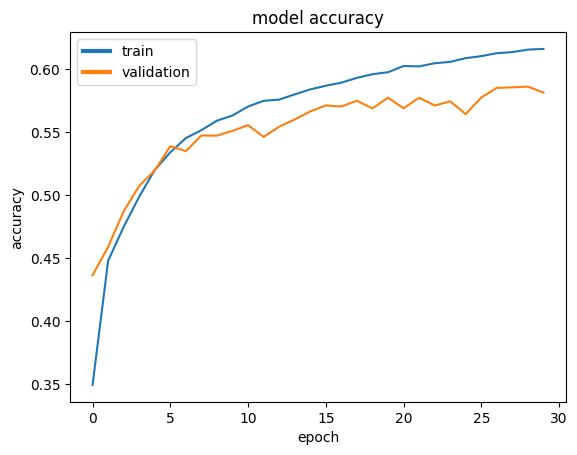

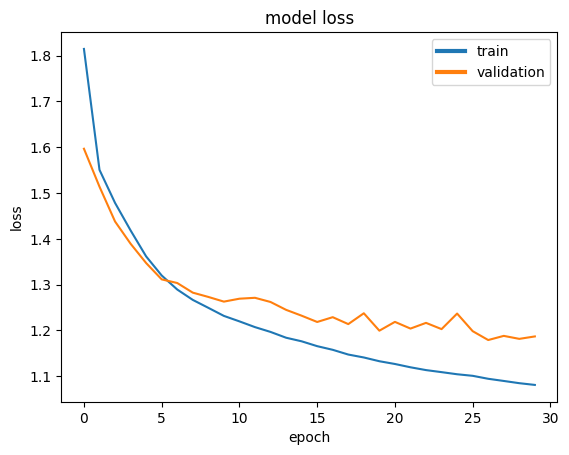

In [24]:
# adam
show_scores1(model2, h2, X_train, Y_train, X_test, Y_test)

For list of all optimizers, see:
https://keras.io/api/optimizers/

Below is an example to use RMSprop.

In [ ]:
nb_epoch = 10
batch_size = 64

model0 = Sequential()
model0.add(Convolution2D(5, 2, 2, input_shape=(32, 32, 3), padding='same',  activation='relu')) # add parameters and activation function
model0.add(Convolution2D(20, 2, 2, activation='relu')) # add parameters and activation function
model0.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model0.add(Flatten())
model0.add(Dense(32, activation='relu')) # add parameters and activation function
model0.add(Dense(nb_classes, activation='softmax')) # activation function
# Compile model
model0.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
print(model0.summary())
print('Standard Training.')
h0 = model0.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 5)         65        
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 20)          420       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                10272     
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                      